# Text Classification - Romeo Silvestri

Questo notebook si concentra sull'utilizzo del dataset "Japanese Newspapers 2005-2021" reperibile su Kaggle. L'obiettivo principale è eseguire un'analisi esaustiva dei dati presenti nei giornali giapponesi. Per agevolare la collaborazione e il controllo delle versioni, sarà creata una codebase Git condivisa.

Inizialmente, verranno sviluppati notebook interattivi con grafici selezionati per visualizzare le principali caratteristiche del dataset. Questi grafici aiuteranno a comprendere meglio la distribuzione delle fonti giornalistiche, il periodo in cui gli articoli sono stati pubblicati, la frequenza delle parole chiave e la polarità dei sentimenti nei testi.

Successivamente, ci concentreremo sull'addestramento di un classificatore, il cui compito sarà predire in quale giornale è stato scritto un articolo, basandosi sul testo dell'articolo stesso. Verranno calcolate metriche di valutazione per misurare le prestazioni del classificatore.
Un aspetto cruciale del progetto riguarderà l'esplorazione di diversi modelli di machine learning e tecniche di preprocessing dei dati. Questo approccio ci consentirà di confrontare le prestazioni dei vari modelli e identificare l'approccio migliore per il nostro specifico problema.

## Importazione dei dati

In [1]:
import pandas as pd

# Si carica il file "english_news.csv" utilizzando pandas
# Assume che il file sia delimitato da tabulazioni, che il carattere di escape non venga utilizzato e che gli spazi iniziali nei campi siano ignorati
df = pd.read_csv("english_news.csv", delimiter="\t", escapechar=None, engine='python', skipinitialspace=True)

print(df.head)

<bound method NDFrame.head of                  source        date  \
0      Mainichi Shimbun  2021-12-06   
1      Mainichi Shimbun  2021-12-07   
2      Mainichi Shimbun  2021-12-08   
3      Mainichi Shimbun  2021-12-08   
4      Mainichi Shimbun  2021-12-08   
...                 ...         ...   
36884   The Japan Times  2021-06-06   
36885   The Japan Times  2021-06-07   
36886   The Japan Times  2021-06-07   
36887   The Japan Times  2021-06-07   
36888   The Japan Times  2021-06-07   

                                                   title author  \
0      Editorial: Japan govt's 20,000-yen handout mis...    NaN   
1      Editorial: Time for Japan PM Kishida to delive...    NaN   
2      Editorial: 80 years on from Pearl Harbor, acti...    NaN   
3      Yoroku: 80 years later, many lessons still not...    NaN   
4      Promoting respect for human rights behind US '...    NaN   
...                                                  ...    ...   
36884  COVID-19 tracker: Tokyo r

## Pre-Processing e Analisi Esplorativa

In [2]:
# Si eliminano le variabili "title" e "author" che risultano superflue
# Elimina anche gli articoli vuoti, se presenti (gestisce gli errori nei dati)
# Resetta gli indici

df = df.drop(columns=['title', 'author'])
df = df.dropna(subset=['text'])
df = df.reset_index(drop=True)

print(df)

                 source        date  \
0      Mainichi Shimbun  2021-12-06   
1      Mainichi Shimbun  2021-12-07   
2      Mainichi Shimbun  2021-12-08   
3      Mainichi Shimbun  2021-12-08   
4      Mainichi Shimbun  2021-12-08   
...                 ...         ...   
36761   The Japan Times  2021-06-06   
36762   The Japan Times  2021-06-07   
36763   The Japan Times  2021-06-07   
36764   The Japan Times  2021-06-07   
36765   The Japan Times  2021-06-07   

                                                    text  
0      The Japanese government is trying to boost the...  
1      Prime Minister Fumio Kishida, who won a public...  
2      It has been 80 years since the start of the Pa...  
3      "The world has changed completely. The era was...  
4      The U.S. administration under President Joe Bi...  
...                                                  ...  
36761  Tokyo confirmed 351 new cases of COVID-19 on S...  
36762  The dollar eased to around ¥109.40 in Tokyo tr...  


In [3]:
# Stampa la tabella di frequenza per i 2 giornali

freq_tab = df['source'].value_counts()

print(freq_tab)

The Japan Times     36692
Mainichi Shimbun       74
Name: source, dtype: int64


E' da notare che le classi di questo dataset sono fortemente sbilanciate

In [4]:
# Trasforma la variabile "date" in formato datetime
# Visualizza il tipo di dati delle variabili del dataframe

df['date'] = pd.to_datetime(df['date'])
data_types = df.dtypes

print(data_types)

source            object
date      datetime64[ns]
text              object
dtype: object


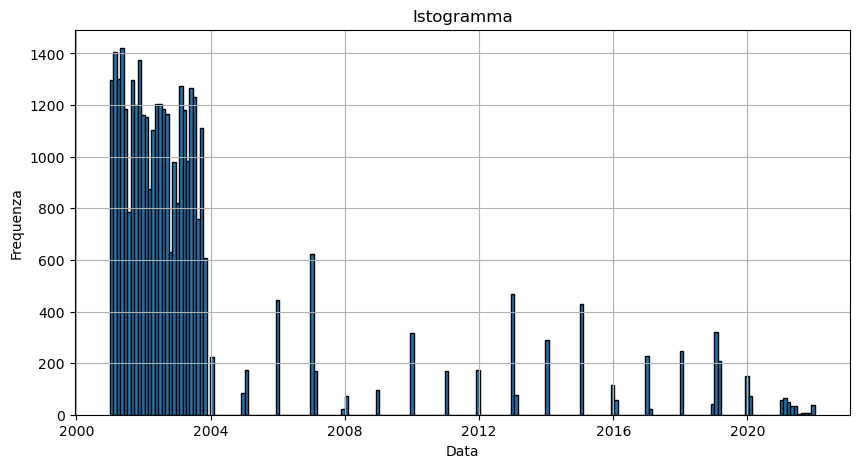

In [5]:
import matplotlib.pyplot as plt

# Istogramma delle date di pubblicazione di tutti gli articoli

plt.figure(figsize=(10, 5))
plt.hist(df['date'], bins='auto', edgecolor='k')
plt.xlabel('Data')
plt.ylabel('Frequenza')
plt.title('Istogramma')
plt.grid(True)
plt.show()

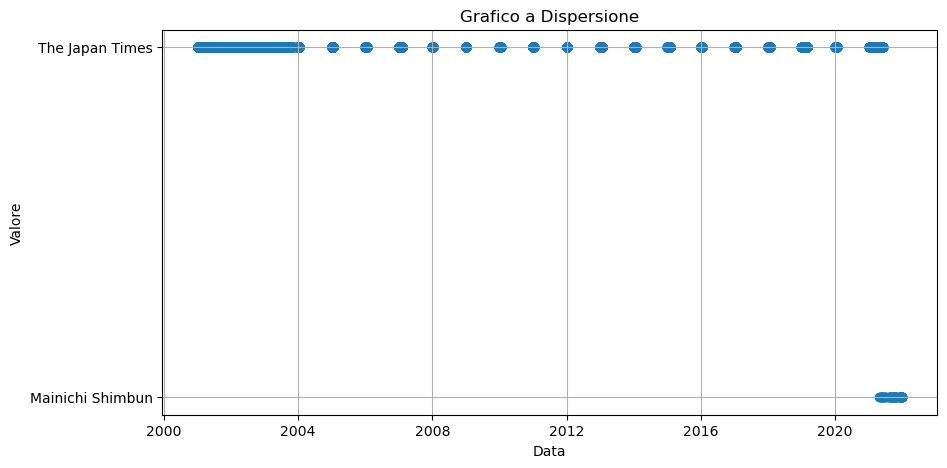

In [6]:
# Grafico a dispersione delle date degli articoli differenziato per giornale

plt.figure(figsize=(10, 5))
plt.scatter(df['date'], df['source'])
plt.xlabel('Data')
plt.ylabel('Valore')
plt.title('Grafico a Dispersione')
plt.grid(True)
plt.show()

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import words as nltk_words

# Scarica le risorse di tipo NLP necessarie
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')

stop_words = set(stopwords.words('english'))  # stop-words (parole prive di significato)
english_words = set(nltk_words.words('en'))   # parole del dizionario inglese
stemmer = PorterStemmer()                     # stemmer (serve per estrarre la radice delle parole)


# Definisce una funzione che normalizza il testo pulendolo dagli elementi non necessari
def normalize_text(text):
    
    text = text.lower()                      # trasforma il testo in minuscolo
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # elimina tutti i caratteri speciali dal testo, compresi segni di punteggiatura e numeri
    
    # Tokenizzazione (trasforma il testo in token, ovvero in parole singole)
    words = word_tokenize(text)
    
    # Stemming con eliminazione delle stop-words e delle parole non presenti nel dizionario inglese
    words = [stemmer.stem(word) for word in words if word not in stop_words and word in english_words]
    
    # Lemmatizzazione (processo inverso della tokenizzazione)
    normalized_text = ' '.join(words)
    return normalized_text


df['text'] = df['text'].apply(normalize_text)             # applica la normalizzazione del testo

df = df[df['text'].apply(lambda x: len(x.split()) >= 5)]  # elimina i documenti con meno di 5 parole utili

print(df)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\silve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\silve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\silve\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


                 source       date  \
0      Mainichi Shimbun 2021-12-06   
1      Mainichi Shimbun 2021-12-07   
2      Mainichi Shimbun 2021-12-08   
3      Mainichi Shimbun 2021-12-08   
4      Mainichi Shimbun 2021-12-08   
...                 ...        ...   
36761   The Japan Times 2021-06-06   
36762   The Japan Times 2021-06-07   
36763   The Japan Times 2021-06-07   
36764   The Japan Times 2021-06-07   
36765   The Japan Times 2021-06-07   

                                                    text  
0      govern tri boost uptak number person id number...  
1      prime minist public mandat administr hous elec...  
2      sinc start pacif war imperi surpris attack pea...  
3      world complet era enorm came yesterday like di...  
4      us administr presid joe decid diplomat boycott...  
...                                                  ...  
36761  confirm new covid prefectur new remain peak so...  
36762  dollar around trade direct amid lack fresh dol...  
36763  avera

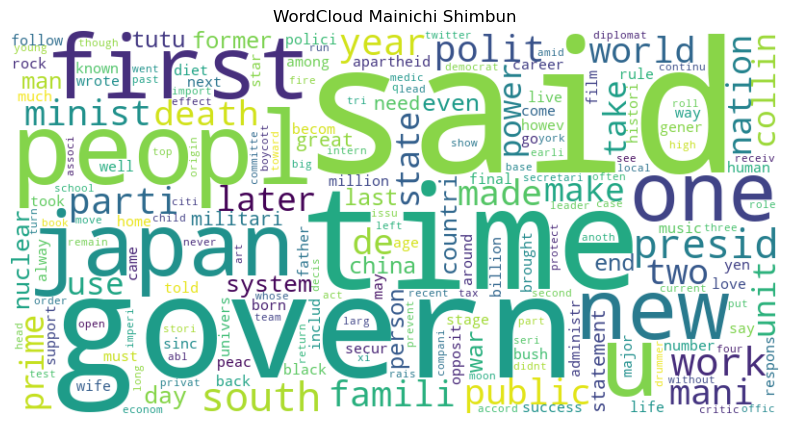

In [8]:
from wordcloud import WordCloud

# Filtra il dataset solo per il giornale "Mainichi Bum"
df_mb = df[df['source'] == 'Mainichi Shimbun']

# Unisce tutti gli articoli corrispondenti a "Mainichi Bum" in una singola stringa
all_text_mb = " ".join(text for text in df_mb['text'])

# Crea un WordCloud di parole
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(all_text_mb)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordCloud Mainichi Shimbun")
plt.axis('off')
plt.show()

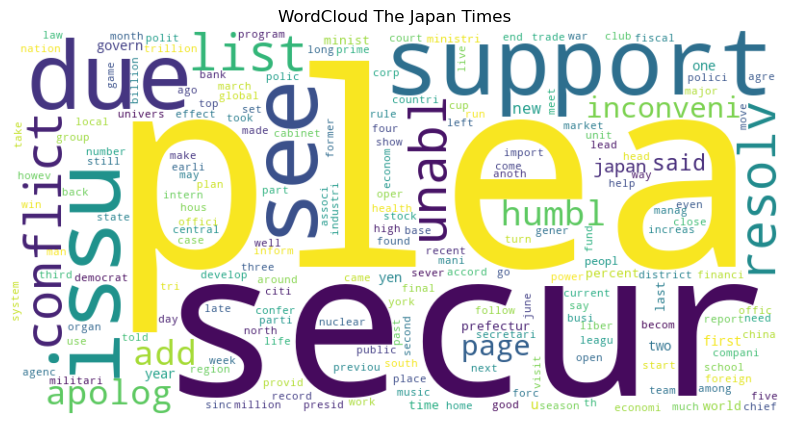

In [9]:
# Filtra il dataset solo per il giornale "The Japan Times"

df_jt = df[df['source'] == 'The Japan Times']
all_text_jt = " ".join(text for text in df_jt['text'])

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(all_text_jt)

# Visualizza il WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordCloud The Japan Times")
plt.axis('off')
plt.show()

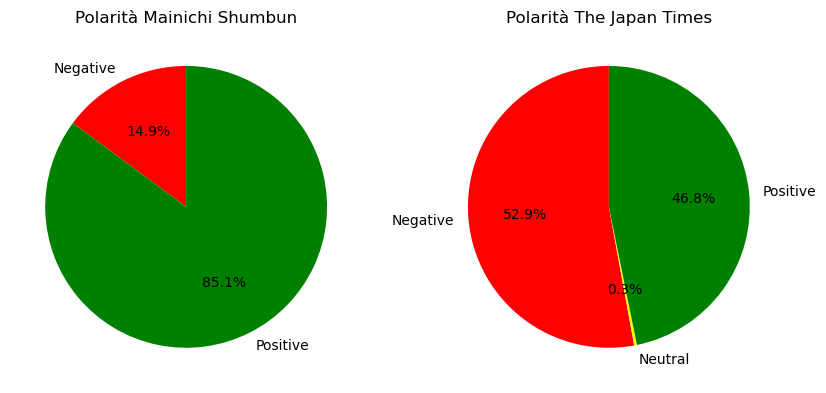

In [10]:
from textblob import TextBlob

# Funzione per estrarre la polarità dei sentimenti
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    if sentiment_score > 0:
        return 'Positive'
    elif sentiment_score < 0:
        return 'Negative'
    else:
        return 'Neutral'


df['sentiment'] = df['text'].apply(get_sentiment)
sentiment_distribution = df.groupby(['source', 'sentiment']).size().reset_index(name='count')

# Filtra i risultati per giornale
sentiment_ms = sentiment_distribution[sentiment_distribution['source'] == 'Mainichi Shimbun']
sentiment_jt = sentiment_distribution[sentiment_distribution['source'] == 'The Japan Times']

# Crea grafici a torta della polarità dei sentimenti
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sentiment_colors = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'yellow'}

# Grafico 1
ax1.pie(sentiment_ms['count'], labels=sentiment_ms['sentiment'], autopct='%1.1f%%', startangle=90, colors=sentiment_ms['sentiment'].map(sentiment_colors))
ax1.set_title("Polarità Mainichi Shumbun")

# Grafico 2
ax2.pie(sentiment_jt['count'], labels=sentiment_jt['sentiment'], autopct='%1.1f%%', startangle=90, colors=sentiment_jt['sentiment'].map(sentiment_colors))
ax2.set_title("Polarità The Japan Times")

plt.show()

## Classificazione

I modelli di classificazione che sono stati messi a confronto sono:
1) Regressione Logistica
2) Support Vector Machine (SVM)
3) Random Forest
4) XG-Boost

I modelli sono stati allenati e messi a confronto sulla base della metrica F1-Score perché utile per classi sbilanciate. Si è anche utilizzata la tecnica del 10-fold cross-validation stratificata per la variabile target per validare e, talvolta, allenare gli iperparametri dei modelli.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression

# Divide il dataset in training set e test set stratificando per i giornali
X = df['text']
y = df['source']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

# Vettorizzazione TF-IDF
vectorizer = TfidfVectorizer(min_df=5, max_features=1500)  # si tengono le 1500 parole più frequenti e presenti in almeno 5 articoli
X_train_vec = vectorizer.fit_transform(X_train)

# Inizializza un classificatore di Regressione Logistica con classi bilanciate
classifier = LogisticRegression(class_weight='balanced')

# Applica il modello
classifier.fit(X_train_vec, y_train)

# Calcola la metrica F1-Score sul training set
y_train_pred = classifier.predict(X_train_vec)            
f1_train = f1_score(y_train, y_train_pred, average='macro')

# Definisce la k-fold cross-validation stratificata (k=10)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
f1_scorer = make_scorer(f1_score, average='macro')

# Performa la cross-validation
f1_scores = cross_val_score(classifier, X_train_vec, y_train, cv=cv, scoring=f1_scorer)

# Stampa i risultati
print("F1-Score sul training set: {:.3g}".format(f1_train))
print("F1-Score di cross-validation: {:.3g}".format(f1_scores.mean()))

F1-Score sul training set: 0.866
F1-Score di cross-validation: 0.836


In [12]:
# Previsioni

X_test_vec = vectorizer.transform(X_test)
y_pred = classifier.predict(X_test_vec)

print("Matrice di confusione sul Test Set:")
print(confusion_matrix(y_test, y_pred))

print("Report di Classificazione:")
print(classification_report(y_test, y_pred))

# F1-Score sul test set
f1 = f1_score(y_test, y_pred, average='macro')

# Stampa lo Score
print("F1-Score: {:.3g}".format(f1))

Matrice di confusione sul Test Set:
[[  14    1]
 [  10 7329]]
Report di Classificazione:
                  precision    recall  f1-score   support

Mainichi Shimbun       0.58      0.93      0.72        15
 The Japan Times       1.00      1.00      1.00      7339

        accuracy                           1.00      7354
       macro avg       0.79      0.97      0.86      7354
    weighted avg       1.00      1.00      1.00      7354

F1-Score: 0.859


In [13]:
from sklearn.svm import SVC

# Inizializza un classificatore SVC lineare
classifier = SVC(kernel='linear', class_weight='balanced')
classifier.fit(X_train_vec, y_train)

y_train_pred = classifier.predict(X_train_vec)
f1_train = f1_score(y_train, y_train_pred, average='macro')

f1_scores = cross_val_score(classifier, X_train_vec, y_train, cv=cv, scoring=f1_scorer)

print("F1-Score sul training set: {:.3g}".format(f1_train))
print("F1-Score di cross-validation: {:.3g}".format(f1_scores.mean()))

F1-Score sul training set: 0.984
F1-Score di cross-validation: 0.795


In [14]:
y_pred = classifier.predict(X_test_vec)

print("Matrice di confusione sul Test Set:")
print(confusion_matrix(y_test, y_pred))

print("Report di Classificazione:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='macro')
print("F1-score: {:.3g}".format(f1))

Matrice di confusione sul Test Set:
[[   9    6]
 [   2 7337]]
Report di Classificazione:
                  precision    recall  f1-score   support

Mainichi Shimbun       0.82      0.60      0.69        15
 The Japan Times       1.00      1.00      1.00      7339

        accuracy                           1.00      7354
       macro avg       0.91      0.80      0.85      7354
    weighted avg       1.00      1.00      1.00      7354

F1-score: 0.846


In [15]:
from sklearn.ensemble import RandomForestClassifier

# Inizializza un classificatore Random Forest
classifier = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=123)
classifier.fit(X_train_vec, y_train)

y_train_pred = classifier.predict(X_train_vec)
f1_train = f1_score(y_train, y_train_pred, average='macro')

f1_scores = cross_val_score(classifier, X_train_vec, y_train, cv=cv, scoring=f1_scorer)

print("F1-Score sul training set: {:.3g}".format(f1_train))
print("F1-Score di cross-validation: {:.3g}".format(f1_scores.mean()))

F1-Score sul training set: 0.918
F1-Score di cross-validation: 0.837


In [16]:
y_pred = classifier.predict(X_test_vec)

print("Matrice di confusione sul Test Set:")
print(confusion_matrix(y_test, y_pred))

print("Report di Classificazione:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='macro')
print("F1-score: {:.3g}".format(f1))

Matrice di confusione sul Test Set:
[[  15    0]
 [   7 7332]]
Report di Classificazione:
                  precision    recall  f1-score   support

Mainichi Shimbun       0.68      1.00      0.81        15
 The Japan Times       1.00      1.00      1.00      7339

        accuracy                           1.00      7354
       macro avg       0.84      1.00      0.91      7354
    weighted avg       1.00      1.00      1.00      7354

F1-score: 0.905


In [17]:
from sklearn.model_selection import GridSearchCV

# Definisce gli iper-parametri per la Grid Search
param_grid = {
    'max_depth': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [25, 50, 100],
}

# Esegue la Grid Search
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train_vec, y_train)

# Ricava i migliori risultati ottenuti
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_classifier = grid_search.best_estimator_

print("Migliori Parametri:", best_params)
print("Miglior F1-Score: {:.3g}".format(best_score))

y_pred = best_classifier.predict(X_test_vec)

print("Matrice di confusione sul Test Set:")
print(confusion_matrix(y_test, y_pred))

print("Report di Classificazione:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='macro')
print("F1-Score: {:.3g}".format(f1))

Migliori Parametri: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Miglior F1-Score: 0.848
Matrice di confusione sul Test Set:
[[  14    1]
 [   8 7331]]
Report di Classificazione:
                  precision    recall  f1-score   support

Mainichi Shimbun       0.64      0.93      0.76        15
 The Japan Times       1.00      1.00      1.00      7339

        accuracy                           1.00      7354
       macro avg       0.82      0.97      0.88      7354
    weighted avg       1.00      1.00      1.00      7354

F1-Score: 0.878


In [18]:
import xgboost as xgb

# Converte le etichette delle classi in numeriche
class_mapping = {label: idx for idx, label in enumerate(y_train.unique())}
y_train = y_train.map(class_mapping)
y_test = y_test.map(class_mapping)

# Inizializza un classificatore XG-Boost
classifier = xgb.XGBClassifier(scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum())  # aggiustamento per classi sbilanciate
classifier.fit(X_train_vec, y_train)

y_train_pred = classifier.predict(X_train_vec)
f1_train = f1_score(y_train, y_train_pred, average='macro')

f1_scores = cross_val_score(classifier, X_train_vec, y_train, cv=cv, scoring=f1_scorer)

print("F1-Score sul training set: {:.3g}".format(f1_train))
print("F1-Score di cross-validation: {:.3g}".format(f1_scores.mean()))

F1-Score sul training set: 1
F1-Score di cross-validation: 0.877


In [19]:
y_pred = classifier.predict(X_test_vec)

print("Matrice di confusione sul Test Set:")
print(confusion_matrix(y_test, y_pred))

print("Report di Classificazione:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='macro')
print("F1-score: {:.3g}".format(f1))

Matrice di confusione sul Test Set:
[[7335    4]
 [   0   15]]
Report di Classificazione:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7339
           1       0.79      1.00      0.88        15

    accuracy                           1.00      7354
   macro avg       0.89      1.00      0.94      7354
weighted avg       1.00      1.00      1.00      7354

F1-score: 0.941


In [20]:
param_grid = {
    'learning_rate': [0.2, 0.3, 0.5],
    'max_depth': [2, 3, 5, 10],
    'n_estimators': [50, 100, 200],
    'scale_pos_weight': [(len(y_train) - y_train.sum()) / y_train.sum()]
}

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='f1_macro')
grid_search.fit(X_train_vec, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_classifier = grid_search.best_estimator_

print("Migliori Parametri:", best_params)
print("Miglior F1-Score: {:.3g}".format(best_score))

y_pred = best_classifier.predict(X_test_vec)

print("Matrice di confusione sul Test Set:")
print(confusion_matrix(y_test, y_pred))

print("Report di Classificazione:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='macro')
print("F1-Score: {:.3g}".format(f1))

Migliori Parametri: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50, 'scale_pos_weight': 497.50847457627117}
Miglior F1-Score: 0.89
Matrice di confusione sul Test Set:
[[7335    4]
 [   0   15]]
Report di Classificazione:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7339
           1       0.79      1.00      0.88        15

    accuracy                           1.00      7354
   macro avg       0.89      1.00      0.94      7354
weighted avg       1.00      1.00      1.00      7354

F1-Score: 0.941


Il modello di tipo XG-Boost risulta essere il migliore in questo tipo di analisi con un F1-Score di cross-validation pari a 0,89 e un F1-Score di Test pari a 0,941.

Si potrebbero allenare altri tipi di modelli per questa task come architetture di Deep Learning. Per questo tipo specifico di problemi, ad esempio, negli ultimi anni i modelli Transformers sono risultati particolarmente accurati.